In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [3]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')

In [4]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [5]:
atlas = src.graph.graph_from_json('atlas.json')

In [6]:
cities = src.graph.graph_from_json('cities.json')

In [33]:
print(f'#{255:02x}{214:02x}{1:02x}')

#ffd601


In [35]:
print(f'#{193:02x}{1:02x}{120:02x}')

#c10178


In [34]:
print(f'#{63:02x}{154:02x}{11:02x}')

#3f9a0b


In [43]:
tesla = []
rivian = []
non_proprietary = []

for source, node in graph._node.items():

    if node['type'] == 'station':

        if 'Tesla' in node['network']:

            tesla.append(source)

        elif 'RIVIAN' in node['network']:

            rivian.append(source)

        else:

            non_proprietary.append(source)

tesla_sng = src.graph.subgraph(graph, tesla)
rivian_sng = src.graph.subgraph(graph, rivian)
non_proprietary_sng = src.graph.subgraph(graph, non_proprietary)

In [52]:
for source, node in graph._node.items():

    if node['type'] == 'station':

        if 'Tesla' in node['network']:

            node['plc'] = 2

        elif 'RIVIAN' in node['network']:

            node['plc'] = 1

        else:

            node['plc'] = 0
            
    else:

        node['plc'] = np.nan

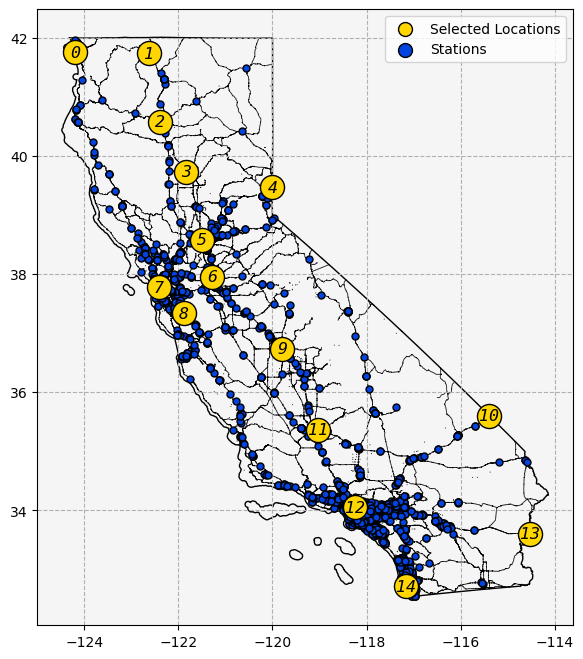

In [114]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 25,
        'ec': 'k',
        'fc': 'xkcd:blue',
        'zorder': 2,
        'label': 'Stations',
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_All.png', bbox_inches = 'tight', dpi = 300)

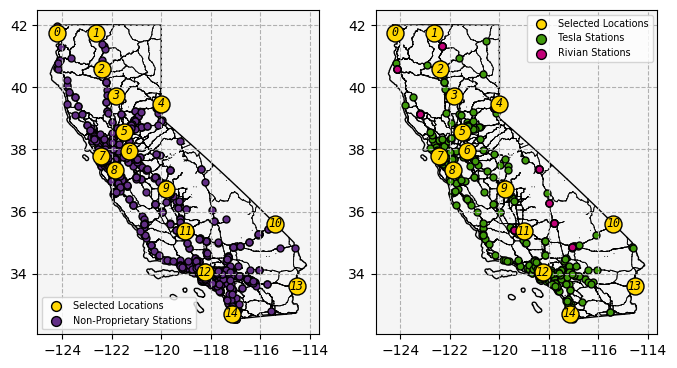

In [97]:
fig, ax = plt.subplots(1, 2, figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax[0], fc = 'none', ec = 'k')
outline[outline['STATEFP'] == '06'].plot(ax = ax[1], fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax[0], **kw)
src.figures.plot_graph(atlas, ax = ax[1], **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 150,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax[0], **kw)
src.figures.plot_graph(cities, ax = ax[1], **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'small',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax[0].text(x[idx], y[idx], n[idx], **kw)
    ax[1].text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax[0].set(**kw)
ax[1].set(**kw)

kw = {
    'ls': 'dashed',
}

ax[0].grid(**kw)
ax[1].grid(**kw)


kw = {
    'show_links': False,
    'scatter': {
        's': 25,
        'ec': 'k',
        'fc': '#622e86',
        'zorder': 1,
        'label': 'Non-Proprietary Stations',
    },
}

src.figures.plot_graph(non_proprietary_sng, ax = ax[0], **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 25,
        'ec': 'k',
        'fc': '#3f9a0b',
        'zorder': 1,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(tesla_sng, ax = ax[1], **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 25,
        'ec': 'k',
        'fc': '#c10178',
        'zorder': 2,
        'label': 'Rivian Stations',
    },
}

src.figures.plot_graph(rivian_sng, ax = ax[1], **kw)

kw = {
    'fontsize': 'x-small',
}
    

legend = ax[0].legend(**kw)

for h in legend.legendHandles:
    h._sizes = [50]
    
legend = ax[1].legend(**kw)

for h in legend.legendHandles:
    h._sizes = [50]

fig.savefig('Paper/figs/California_SNG_Horizontal.png', bbox_inches = 'tight', dpi = 300)

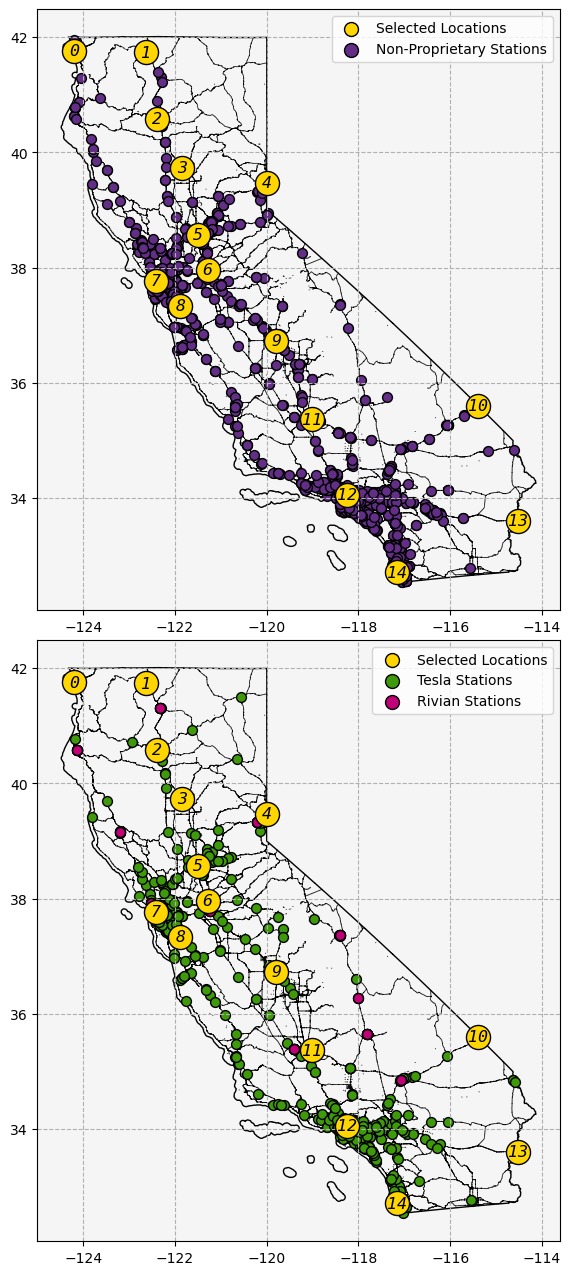

In [115]:
fig, ax = plt.subplots(2, 1, figsize = (8, 16), gridspec_kw = {'hspace': .05})

outline[outline['STATEFP'] == '06'].plot(ax = ax[0], fc = 'none', ec = 'k')
outline[outline['STATEFP'] == '06'].plot(ax = ax[1], fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax[0], **kw)
src.figures.plot_graph(atlas, ax = ax[1], **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax[0], **kw)
src.figures.plot_graph(cities, ax = ax[1], **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax[0].text(x[idx], y[idx], n[idx], **kw)
    ax[1].text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax[0].set(**kw)
ax[1].set(**kw)

kw = {
    'ls': 'dashed',
}

ax[0].grid(**kw)
ax[1].grid(**kw)


kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#622e86',
        'zorder': 1,
        'label': 'Non-Proprietary Stations',
    },
}

src.figures.plot_graph(non_proprietary_sng, ax = ax[0], **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#3f9a0b',
        'zorder': 1,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(tesla_sng, ax = ax[1], **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#c10178',
        'zorder': 2,
        'label': 'Rivian Stations',
    },
}

src.figures.plot_graph(rivian_sng, ax = ax[1], **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax[0].legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    
legend = ax[1].legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]

fig.savefig('Paper/figs/California_SNG_Vertical.png', bbox_inches = 'tight', dpi = 300)

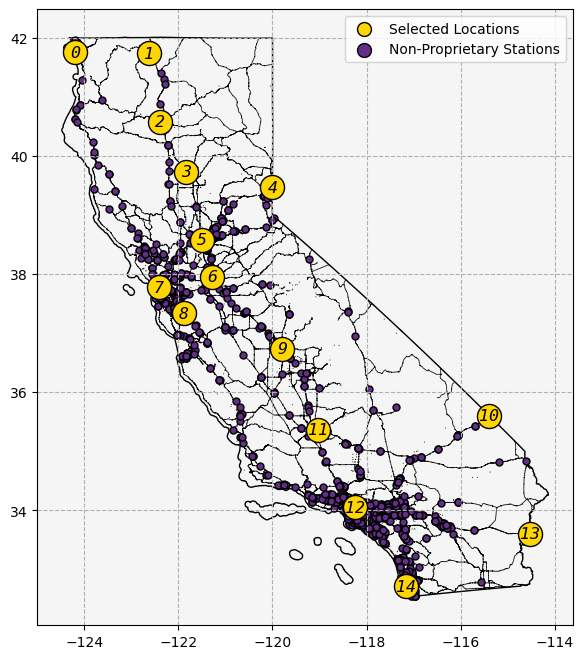

In [106]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 25,
        'ec': 'k',
        'fc': '#622e86',
        'zorder': 1,
        'label': 'Non-Proprietary Stations',
    },
}

src.figures.plot_graph(non_proprietary_sng, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_NP.png', bbox_inches = 'tight', dpi = 300)

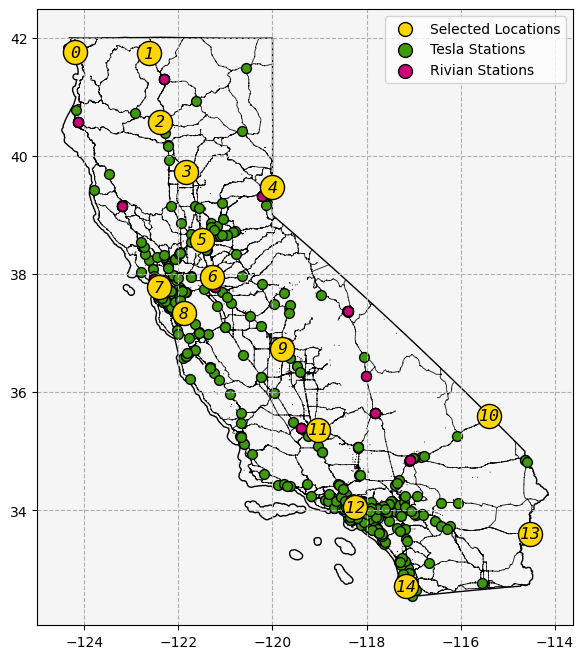

In [119]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#3f9a0b',
        'zorder': 1,
        'label': 'Tesla Stations',
    },
}

src.figures.plot_graph(tesla_sng, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#cc0178',
        'zorder': 2,
        'label': 'Rivian Stations',
    },
}

src.figures.plot_graph(rivian_sng, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_P.png', bbox_inches = 'tight', dpi = 300)

In [132]:
for source, node in graph._node.items():

    if node['type'] != 'station':

        node['n_dcfc_d'] = np.nan

    else:

        node['n_dcfc_d'] = np.digitize(node['n_dcfc'], list(range(10)))

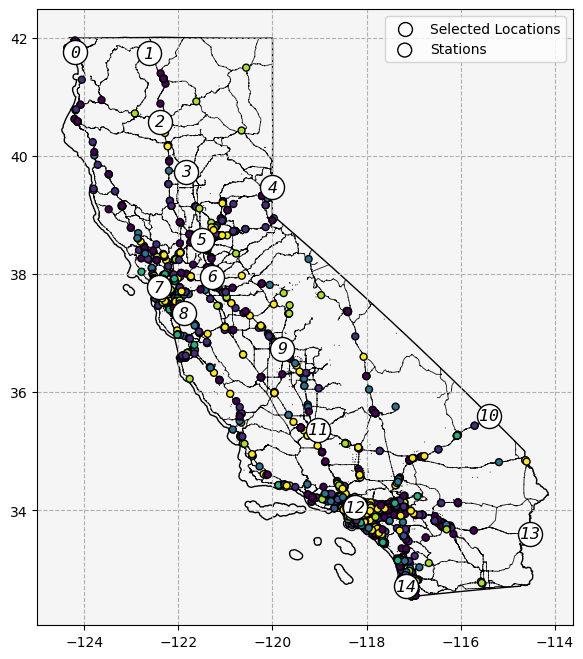

In [133]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'white',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc_d',
    'scatter': {
        's': 25,
        'ec': 'k',
        # 'fc': 'xkcd:blue',
        'zorder': 2,
        'label': 'Stations',
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

# fig.savefig('Paper/figs/California_SNG_All.png', bbox_inches = 'tight', dpi = 300)

In [128]:
np.digitize(9, [0, 1, 2, 3, 4])

5

In [136]:
for source, node in graph._node.items():

    if node['type'] != 'station':

        node['n_dcfc_r'] = np.nan

    else:

        node['n_dcfc_r'] = 0

        for target, edge in graph._adj[source].items():

            node['n_dcfc_r'] += edge['distance'] <= 200e3

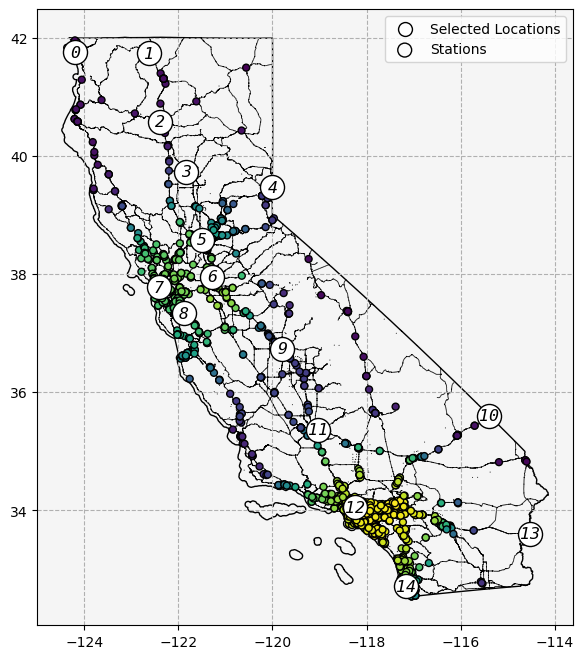

In [137]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': 'white',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(cities, ax = ax, **kw)

x = [n['x'] for n in cities._node.values()]
y = [n['y'] for n in cities._node.values()]
n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc_r',
    'scatter': {
        's': 25,
        'ec': 'k',
        # 'fc': 'xkcd:blue',
        'zorder': 2,
        'label': 'Stations',
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

In [219]:
from scipy.stats import rv_histogram

x = list(range(1, 51))

n_np = []

for source, node in non_proprietary_sng._node.items():

    n_np.append(node['n_dcfc'])

n_t = []

for source, node in tesla_sng._node.items():
# for source, node in rivian_sng._node.items():

    n_t.append(node['n_dcfc'])

h_np = rv_histogram(np.histogram(n_np, bins = x))
h_t = rv_histogram(np.histogram(n_t, bins = x))

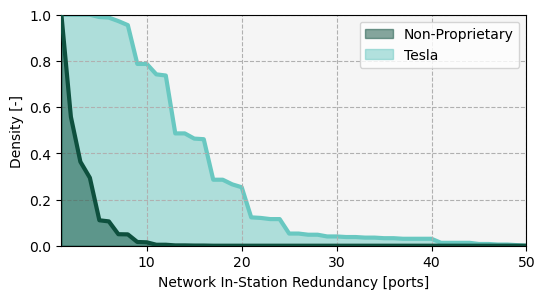

In [220]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_np.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'Non-Proprietary'
}

ax.fill_between(x, 0, h_np.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_t.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Tesla'
}

ax.fill_between(x, 0, h_t.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'Network In-Station Redundancy [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

fig.savefig('Paper/figs/California_RIS_Hist.png', bbox_inches = 'tight', dpi = 300)

In [221]:
def redundancy_between_nodes(graph, field = 'distance', cutoff = 10e3):

    graph_c = graph.copy()

    for source, adj in graph_c._adj.items():
    
        new_adj = {}
        
        for target, edge in adj.items():
    
            if edge[field] <= cutoff:
    
                new_adj[target] = edge
    
        graph_c._adj[source] = new_adj

    cliques = list(nx.find_cliques(graph_c))

    n = []
    
    for clique in cliques:
    
        n.append(sum([graph_c._node[c]['n_dcfc'] for c in clique]))

    return n

In [222]:
x = list(range(1, 51))

kw = {
    'field': 'time',
    'cutoff': 600,
}

n_np = redundancy_between_nodes(non_proprietary_sng, **kw)
n_t = redundancy_between_nodes(tesla_sng, **kw)

h_np = rv_histogram(np.histogram(n_np, bins = x))
h_t = rv_histogram(np.histogram(n_t, bins = x))

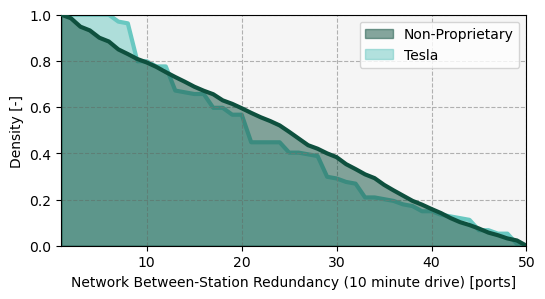

In [223]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_np.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'Non-Proprietary'
}

ax.fill_between(x, 0, h_np.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_t.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Tesla'
}

ax.fill_between(x, 0, h_t.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'Network Between-Station Redundancy (10 minute drive) [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

fig.savefig('Paper/figs/California_RBS_Hist.png', bbox_inches = 'tight', dpi = 300)